# Previsão de picos de CPU

### Carregando bibliotecas:

In [96]:
import warnings
warnings.filterwarnings("ignore")
import operator
import statistics
import collections
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.initializers import VarianceScaling
from keras.regularizers import l2
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import KFold

### Selecionando dados:

In [97]:
data = pd.read_csv('/home/vinhali/Desktop/classification/data/cpu-7day.csv')

In [98]:
data

,data,"""cpu"""
0,7/11/2020 0:00,27.6
1,7/11/2020 0:01,0.7
2,7/11/2020 0:02,1.0
3,7/11/2020 0:03,2.7
4,7/11/2020 0:04,0.9
...,...,...
10075,7/17/2020 23:55,29.8
10076,7/17/2020 23:56,8.7
10077,7/17/2020 23:57,13.6
10078,7/17/2020 23:58,2.1


### Funções de modelamento:

#### Entrada da camada:

>m1 = Média de 12 leituras (Em uma janela de 60 dados) - Exemplo ((2 + 5 + 7 ...) / 12

>d1 = desvio padrão dos 12 dados

E assim sucessivamente até formar m5, d5 (12x5 = 60)

#### Saída da camada:

>0-20 = Quantas vezes os valores são repetidos no intervalo de 0 a 20 nas próximas 30 leituras (Linha 61,62,62 ...)

E assim sucessivamente até formar 20-40.40-60.60-80.80-100

#### Transformando em 0 e 1

Em seguida é selecionado a maior ocorrência de cada coluna e dividido todos os valores da respectiva coluna pela maior ocorrência, exemplo:

>m1 = (Xn > Xn) / Xn

In [99]:
def histogramNeuronsInput(result):
    """ Generates histogram of input neurons """
    
    fig, ax = plt.subplots(figsize=(8,4))
    for i in range(len(result)):
        data = np.array(result[i])
        x=np.arange(len(data)) + i*6
        # draw averages
        ax.bar(x-0.2, data[:,0], color='C0', width=0.4)
        # draw std
        ax.bar(x+0.2, data[:,1], color='C1', width=0.4)
    # turn off xticks
    ax.set_xticks([])
    ax.legend(labels=['Average', 'Standard deviation'])
    leg = ax.get_legend()
    leg.legendHandles[0].set_color('C0')
    leg.legendHandles[1].set_color('C1')
    plt.ylabel('Consume')
    plt.xlabel('Number of elements (Every 5 is a new block)')

    return plt.show()

def histogramNeuronsOutput(result):
    """ Generates histogram of output neurons """
    
    colors = ['blue', 'green', 'yellow', 'orange', 'red']
    labels = ['0-20', '20-40', '40-60', '60-80', '80-100']
    fig, ax = plt.subplots(figsize=(10, 6))
    for i, data in enumerate(result):
        x = np.arange(len(data)) + i*6
        bars = ax.bar(x, data, color=colors, width=0.4)
        if i == 0:
            for bar, label in zip(bars, labels):
                bar.set_label(label)
    ax.set_xticks([])
    ax.legend()
    ax.set_title("Histogram")
    ax.set_ylabel('Consume')
    ax.set_xlabel('Percent')
    
    return plt.show()

def standardDeviation(data):
    """ Calculates standard deviation """
    
    return statistics.stdev(data)
       
def average(data):
    """ Calculates average """
    
    return statistics.mean(data)

def captureOcurrences(elements, n):
    """ Capture an X number of elements within a list """
    
    return [elements[i: i+n] for i in range(0, len(elements), n)]

def neuronsInput(elements):
    """ Generates input neuron modeling (5 averages, 5 standard deviations - Between 12 occurrences in a window of 60 readings) """
    
    result = []
    temp = []
    start = 0
    limit = 60
    size = int(len(elements))
    TargetDivision = int(size / 30)
    repetitions = 0
    five = 0

    while repetitions < TargetDivision:
        temp = []

        five += 1
        ocurrences = captureOcurrences(elements[start: limit],12)
        for i in ocurrences:
            m = average(i)
            sd = standardDeviation(i)
            temp.append([m,sd])

        result.append(temp)

        repetitions += 1
        limit += 10
        start += 10

    return result

def neuronsOutput(elements):
    """ Generates output neuron modeling (Histogram of the next 30 data readings) """
    
    result = []
    start = 61
    limit = 90
    size = int(len(elements))
    TargetDivision = int(size / 30)
    repetitions = 0

    while repetitions < TargetDivision:

        counter=collections.Counter(elements[start: limit])
        
        consumption0_20 = 0
        consumption20_40 = 0
        consumption40_60 = 0
        consumption60_80 = 0
        consumption80_100 = 0
        for key in counter:
            if key <= 20:
                consumption0_20 += int(counter[key])
            elif key > 20 and key < 40:
                consumption20_40 += int(counter[key])
            elif key > 40 and key < 60:
                consumption40_60 += int(counter[key])
            elif key > 60 and key < 80:
                consumption60_80 += int(counter[key])
            elif key > 80 and key < 100:
                consumption80_100 += int(counter[key])

        result.append([consumption0_20,consumption20_40,consumption40_60,consumption60_80,consumption80_100])

        repetitions += 1
        limit += 10
        start += 10

    return result

def binaryInput(data):
    """ I divided the values ​​of each column by the highest occurrence in the column """
    
    max_average = 0
    max_deviation = 0
    for j in range(len(data[0])):
        for i in range(len(data)):
            if data[i][j][0] > max_average:
                max_average = data[i][j][0]
            if data[i][j][1] > max_deviation:
                max_deviation = data[i][j][1]
        for p in range(len(data)):
            if max_average != 0:
                data[p][j][0] = round(data[p][j][0] / max_average, 3)
            if max_deviation != 0:
                data[p][j][1]  = round(data[p][j][1] / max_deviation, 3)
        max_average = 0
        max_deviation = 0
        
    return data

def binaryOutput(data):
    """ I divided the values ​​of each column by the highest occurrence in the column """
    
    max_consume = 0
    reverse = []
    for j in range(len(data[0])):
        for i in range(len(data)):
            if data[i][j] > max_consume:
                max_consume = data[i][j]
        for p in range(len(data)):
            if max_consume != 0:
                data[p][j] = round(data[p][j] / max_consume, 3)

            reverse.append(max_consume)
        max_consume = 0
        
    return data, reverse

def conversionDataframe(dataNeuronInput,dataNeuronOutput):
    """ Converts data to a dataframe pandas """
    
    ni = pd.DataFrame(data= dataNeuronInput)
    ni.columns = ['m1,d1', 'm2,d2', 'm3,d3', 'm4,d4', 'm5,d5']
    no = pd.DataFrame(data= dataNeuronOutput)
    no.columns = ['0-20', '20-40', '40-60', '60-80', '80-100']

    return pd.concat([ni, no], axis=1)

def modeling(data):
    """ Generates the initial model for training the neural network """
    
    readings = data.iloc[:, 1].values
    dataNeuronInput = neuronsInput(readings)
    dataNeuronOutput = neuronsOutput(readings)
    dataFrameNoBinary = conversionDataframe(dataNeuronInput, dataNeuronOutput)
    binaryNeuronInput = binaryInput(dataNeuronInput)
    binaryNeuronOutput, reverseNeuronOutput = binaryOutput(dataNeuronOutput)
    dataFrameBinary = conversionDataframe(binaryNeuronInput, binaryNeuronOutput)

    return dataFrameBinary, np.asarray(captureOcurrences(reverseNeuronOutput,5), dtype=np.float32)

### Histograma: Médias versus Desvio padrão em janelas de 60 leituras

*Antes da divisão pela maior ocorrência de cada critério*

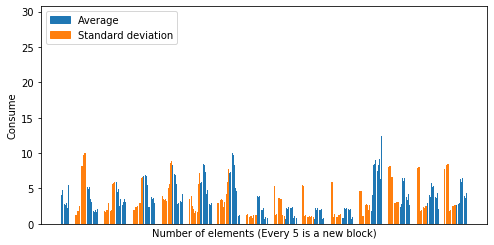

In [100]:
readings = data.iloc[:, 1].values
dataNeuronInput = neuronsInput(readings)
histogramNeuronsInput(dataNeuronInput)

### Picos de consumo de CPU nas próximas 30 leituras das janelas de 60

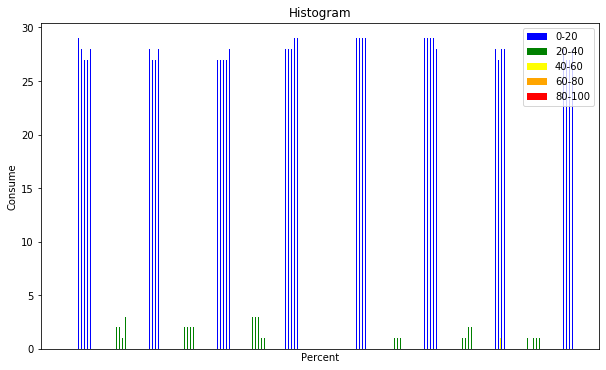

In [101]:
dataNeuronOutput = neuronsOutput(readings)
histogramNeuronsOutput(dataNeuronOutput)

### Transformando X e Y em uma matriz 1D

In [102]:
df, reverse = modeling(data)

X = np.array(df['m1,d1'].values.tolist())
X = np.append(X, np.array(df['m2,d2'].values.tolist()), axis = 1)
X = np.append(X, np.array(df['m3,d3'].values.tolist()), axis = 1)
X = np.append(X, np.array(df['m4,d4'].values.tolist()), axis = 1)
X = np.append(X, np.array(df['m5,d5'].values.tolist()), axis = 1)

Y = []
Y.append(np.asarray(df['0-20'], dtype=np.float32))
Y.append(np.asarray(df['20-40'], dtype=np.float32))
Y.append(np.asarray(df['40-60'], dtype=np.float32))
Y.append(np.asarray(df['60-80'], dtype=np.float32))
Y.append(np.asarray(df['80-100'], dtype=np.float32))
Y = np.transpose(np.asarray(Y))

### Visualizando X:

In [103]:
pd.DataFrame(np.array(X))

,0,1,2,3,4,5,6,7,8,9
0,0.282,0.271,0.267,0.121,0.457,0.314,0.134,0.046,0.423,0.402
1,0.274,0.147,0.460,0.314,0.165,0.067,0.362,0.400,0.418,0.421
2,0.409,0.302,0.174,0.065,0.328,0.399,0.375,0.416,0.225,0.093
3,0.168,0.073,0.126,0.044,0.550,0.544,0.193,0.093,0.599,0.426
4,0.113,0.046,0.564,0.542,0.184,0.091,0.405,0.419,0.570,0.200
...,...,...,...,...,...,...,...,...,...,...
331,0.156,0.101,0.393,0.282,0.139,0.074,0.377,0.272,0.245,0.128
332,0.367,0.272,0.140,0.075,0.343,0.269,0.182,0.118,0.213,0.089
333,0.168,0.142,0.201,0.121,0.331,0.268,0.163,0.087,0.315,0.247
334,0.187,0.123,0.344,0.266,0.154,0.085,0.269,0.246,0.379,0.314


### Visualizando Y:

In [104]:
pd.DataFrame(np.array(Y))

,0,1,2,3,4
0,0.966,0.0,0.5,0.0,0.0
1,0.966,0.0,0.5,0.0,0.0
2,0.966,0.0,0.5,0.0,0.0
3,0.966,0.2,0.0,0.0,0.0
4,0.966,0.2,0.0,0.0,0.0
...,...,...,...,...,...
331,0.931,0.4,0.0,0.0,0.0
332,0.931,0.4,0.0,0.0,0.0
333,0.931,0.4,0.0,0.0,0.0
334,0.966,0.2,0.0,0.0,0.0


In [105]:
X.shape, Y.shape

((336, 10), (336, 5))

### Modelo de aprendizado profundo:

*Descrição do modelo*

>kernel_regularizer = Regularizador de peso da camada

>kernel_initializer = Inicialização da camada

>model.compile = Compilamento do modelo 

>model.fit = Treinamento do modelo

>model.evaluate = Avaliação do modelo

### Preparando cross validation k=5

In [125]:
kfold = KFold(5, False, 1)

In [126]:
for train, test in kfold.split(X,Y):

    model = Sequential()
    model.add(Dense(10,
                kernel_regularizer=l2(0.001),
                kernel_initializer=VarianceScaling(), 
                activation='sigmoid',
                name='hidden-input'))
    model.add(Dense(5, 
                kernel_regularizer=l2(0.001),
                kernel_initializer=VarianceScaling(),                 
                activation='sigmoid',
                name='output'))
    
    model.compile(loss='mse', optimizer='adam', metrics=['mse'])
    
    model.fit(X[train], Y[train], epochs=50, batch_size=5, verbose = 0,
              validation_data=(X[test], Y[test]))

    scores = model.evaluate(X[test], Y[test], verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)

mse: 1.25%
mse: 2.22%
mse: 1.99%
mse: 2.40%
mse: 0.60%


In [127]:
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

55.88% (+/- 47.61%)


In [128]:
model.summary()

Model: "sequential_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden-input (Dense)         multiple                  110       
_________________________________________________________________
output (Dense)               multiple                  55        
Total params: 165
Trainable params: 165
Non-trainable params: 0
_________________________________________________________________


In [135]:
y = model.predict(X)

In [136]:
multiple = []
for i,j in zip(y,reverse):
    multiple.append([i[0] * j[0], i[1] * j[1], i[2] * j[2], i[3] * j[3],  i[4] * j[4]])
    
result = pd.DataFrame(np.array(multiple))

In [137]:
pd.DataFrame(result)

,0,1,2,3,4
0,26.980782,7.045403,1.701835,1.350444,1.540315
1,26.977888,7.053019,1.704687,1.353075,1.543081
2,26.980654,7.045393,1.701844,1.350485,1.540493
3,26.983269,7.045926,1.699753,1.348974,1.538294
4,26.977839,7.057038,1.704918,1.353578,1.543351
...,...,...,...,...,...
331,0.930117,0.243035,0.058903,0.046735,0.053329
332,0.930229,0.242808,0.058796,0.046641,0.053227
333,0.930226,0.242815,0.058801,0.046644,0.053228
334,0.930184,0.243014,0.058847,0.046692,0.053272
